Используя датасет "Пассажиры автобуса", создайте нейронную сеть для решения задачи классификации пассажиров на входящих и выходящих.

Добейтесь точности работы модели выше 90% на проверочной выборке

### Импорты

In [2]:
# загрузка библиотек

# Для работы с файлами
import os

# Для генерации случайных чисел
import random

# Для разархивирования файлов
import zipfile

# Для работы с путями
from pathlib import Path

# Импортируем модуль для загрузки данных
import gdown

# Для отрисовки графиков
import matplotlib.pyplot as plt

# Библиотека работы с массивами
import numpy as np

# Для работы с изображениями
from PIL import Image

# Для создания слоев
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    Input,
    MaxPooling2D,
)

# Для создания сети
from tensorflow.keras.models import Sequential

# Оптимизатор
from tensorflow.keras.optimizers import Adam

# Для работы с генераторами изображений
from tensorflow.keras.preprocessing.image import ImageDataGenerator


### Загрузка и распаковка данных

In [4]:
# загрузка датасета, укажем путь к базе в Google Drive, база в виде .zip-архива
if "bus.zip" in os.listdir():  # проверяем, есть ли файл bus.zip в текущей директории
    pass
else:  # если файла нет, то загружаем его
    gdown.download(
        "https://storage.yandexcloud.net/aiueducation/Content/base/l4/bus.zip",
        None,
        quiet=True,
    )

# Распакуем архив в директорию 'bus'
if "bus" in os.listdir(): # проверяем, есть ли папка bus в текущей директории
    pass
else: # если папки нет, то создаем ее и распаковываем архив
    with zipfile.ZipFile("bus.zip", "r") as zip_ref:
        zip_ref.extractall("bus")

# Папка с папками картинок, рассортированных по категориям
IMAGE_PATH = "bus/"

# Получение списка папок, находящемуся по адресу в скобках
print("Список папок в директории 'bus':", os.listdir(IMAGE_PATH))

Список папок в директории 'bus': ['Входящий', 'Выходящий']


### Подготовка данных

In [5]:
# Определение списка имен классов
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 2, метки классов: ['Входящий', 'Выходящий']


In [7]:
# Получения списка файлов для каждого класса

for cls in CLASS_LIST:
    print(cls, ':', os.listdir(f'{IMAGE_PATH}{cls}/')[:10])

Входящий : ['00297.jpg', '03106.jpg', '04306.jpg', '01866.jpg', '02470.jpg', '03607.jpg', '00421.jpg', '00874.jpg', '01077.jpg', '03415.jpg']
Выходящий : ['00230.jpg', '02463.jpg', '01635.jpg', '00148.jpg', '00997.jpg', '02288.jpg', '00467.jpg', '01546.jpg', '01029.jpg', '01640.jpg']


Отобразим визуально для примера по одному изображению из каждого класса (при помощи функции `.imshow()` из модуля `matplotlib.pyplot`):

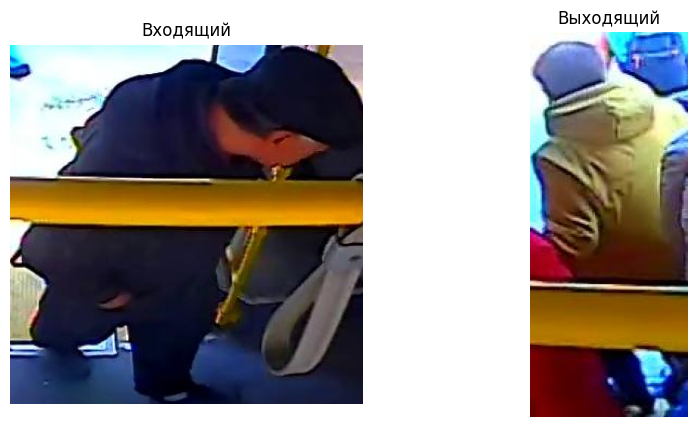

In [8]:
# Создание заготовки для изображений всех классов
fig, axs = plt.subplots(1, CLASS_COUNT, figsize=(10, 5))

# Для всех номеров классов:
for i in range(CLASS_COUNT):

    # Формирование пути к папке содержимого класса
    car_path = f'{IMAGE_PATH}{CLASS_LIST[i]}/'

    # Выбор случайного фото из i-го класса
    img_path = car_path + random.choice(os.listdir(car_path))

    # Отображение фотографии (подробнее будет объяснено далее)
    axs[i].set_title(CLASS_LIST[i])
    axs[i].imshow(Image.open(img_path))
    axs[i].axis('off')

# Отрисовка всего полотна
plt.show()

In [9]:
data_files = []                           # Cписок путей к файлам картинок
data_labels = []                          # Список меток классов, соответствующих файлам

for class_label in range(CLASS_COUNT):    # Для всех классов по порядку номеров (их меток)
    class_name = CLASS_LIST[class_label]  # Выборка имени класса из списка имен
    class_path = IMAGE_PATH + class_name  # Формирование полного пути к папке с изображениями класса
    class_files = os.listdir(class_path)  # Получение списка имен файлов с изображениями текущего класса
    print(f'Размер класса {class_name} составляет {len(class_files)} фото')

    # Добавление к общему списку всех файлов класса с добавлением родительского пути
    data_files += [f'{class_path}/{file_name}' for file_name in class_files]

    # Добавление к общему списку меток текущего класса - их ровно столько, сколько файлов в классе
    data_labels += [class_label] * len(class_files)

print()
print('Общий размер базы для обучения:', len(data_labels))

Размер класса Входящий составляет 4541 фото
Размер класса Выходящий составляет 1818 фото

Общий размер базы для обучения: 6359


In [10]:
TEST_SPLIT = VAL_SPLIT = 0.15  # Доля тестовой и валидационной выборки
TRAIN_PATH = Path("bus")  # Путь к папке с обучающей выборкой
VAL_PATH = Path("bus_val")  # Путь к папке с валидационной выборкой
TEST_PATH = Path("bus_test")  # Путь к папке с тестовой выборкой

# Проверяем, существуют ли папки для тестовой
# и валидационной выборок, если нет, то создаем их и заполняем
if not (TEST_PATH.exists() and VAL_PATH.exists()):
    TEST_PATH.mkdir(exist_ok=True)  # Создаем папку для тестовой выборки
    VAL_PATH.mkdir(exist_ok=True)  # Создаем папку для валидационной выборки

    for classfolder in TRAIN_PATH.iterdir():  # Проходим по всем классам в TRAIN_PATH
        classfolder_test = TEST_PATH / classfolder.name
        classfolder_val = VAL_PATH / classfolder.name

        # Создаем папки классов для тестовой и валидационной выборок
        classfolder_test.mkdir(exist_ok=True)
        classfolder_val.mkdir(exist_ok=True)

        files = list(classfolder.iterdir())  # Получаем список файлов в папке класса
        len_class = len(files)  # Количество файлов в классе
        test_len = int(len_class * TEST_SPLIT)  # Количество файлов для тестовой выборки
        # Количество файлов для валидационной выборки
        val_len = int(len_class * VAL_SPLIT)

        for i, img in enumerate(files):  # Проходим по всем файлам в классе
            # Разделяем файлы на тестовую, валидационную и обучающую выборки
            if i < test_len: 
                img.rename(classfolder_test / img.name) 
            elif i < test_len + val_len:
                img.rename(classfolder_val / img.name)
            else:
                break


### Создание генераторов данных

In [11]:
# ваше решение
# Создание генератора изображений для обучения
datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
)

In [12]:
# Параметры изображений
IMG_HEIGHT = 128 
IMG_WIDTH = 128
# Параметры генератора
BATCH_SIZE = 32

In [13]:
# Обучающая выборка генерируется из папки обучающего набора
train_generator = datagen.flow_from_directory(
    # Путь к обучающим изображениям
    TRAIN_PATH,
    # Параметры требуемого размера изображения
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    # Размер батча
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=True,
    # Указание сгенерировать обучающую выборку
    seed=42,
)

# Проверочная выборка также генерируется из папки обучающего набора
validation_generator = datagen.flow_from_directory(
    VAL_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=True,
    # Указание сгенерировать проверочную выборку
    seed=42,
)

# Тестовая выборка генерируется из папки тестового набора
test_generator = datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False,
    seed=42,
)


Found 6359 images belonging to 2 classes.
Found 1361 images belonging to 2 classes.
Found 1361 images belonging to 2 classes.


In [14]:
print("Разделение на классы обучающей выборки:", np.bincount(train_generator.classes))
print(
    "Разделение на классы валидационной выборки:",
    np.bincount(validation_generator.classes),
)
print("Разделение на классы тестовой выборки:", np.bincount(test_generator.classes))


Разделение на классы обучающей выборки: [4541 1818]
Разделение на классы валидационной выборки: [972 389]
Разделение на классы тестовой выборки: [972 389]


### Создание и обучение модели

In [ ]:
model = Sequential( # Создание модели сети
    [
        Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)), # Входной слой
        # Последовательность сверточных слоев с нормализацией и пулингом
        Conv2D(32, (3, 3), activation="relu", padding="same"),
        BatchNormalization(),
        Dropout(0.1),
        MaxPooling2D(pool_size=(3, 3)),

        Conv2D(64, (3, 3), activation="relu", padding="same"),
        BatchNormalization(),
        MaxPooling2D(pool_size=(3, 3)),

        Conv2D(128, (3, 3), activation="relu", padding="same"),
        BatchNormalization(),
        Dropout(0.1),
        MaxPooling2D(pool_size=(3, 3)),

        Conv2D(256, (3, 3), activation="relu", padding="same"),
        BatchNormalization(),
        MaxPooling2D(pool_size=(3, 3)),

        # Преобразование данных в одномерный вектор
        Flatten(),

        # Полносвязные слои с дропаутом
        Dense(512, activation="relu"),
        Dropout(0.1),
        Dense(256, activation="relu"),
        Dropout(0.1),
        Dense(1, activation="sigmoid"),
    ]
)
# Компиляция модели с оптимизатором Adam и функцией потерь binary_crossentropy
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)


In [ ]:
model.summary() # Вывод информации о модели

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 42, 42, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 42, 42, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 42, 42, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 653,505 (2.49 MB)

 Trainable params: 652,545 (2.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [82]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    verbose=1,
)

Epoch 1/50


199/199 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.7715 - loss: 0.5134 - val_accuracy: 0.7472 - val_loss: 0.6075
Epoch 2/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8963 - loss: 0.2526 - val_accuracy: 0.7171 - val_loss: 0.5248
Epoch 3/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.9319 - loss: 0.1661 - val_accuracy: 0.8920 - val_loss: 0.2251
Epoch 4/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9471 - loss: 0.1223 - val_accuracy: 0.9346 - val_loss: 0.1469
Epoch 5/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.9651 - loss: 0.0896 - val_accuracy: 0.9390 - val_loss: 0.1415
Epoch 6/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9782 - loss: 0.0594 - val_accuracy: 0.9434 - val_loss: 0.1416
Epoch 7/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9815 - loss: 0.0481 - val_accuracy: 0.9324 - val_loss: 0.2034
Epoch 8/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9819 - loss: 0.0474 - val_accuracy: 0.96

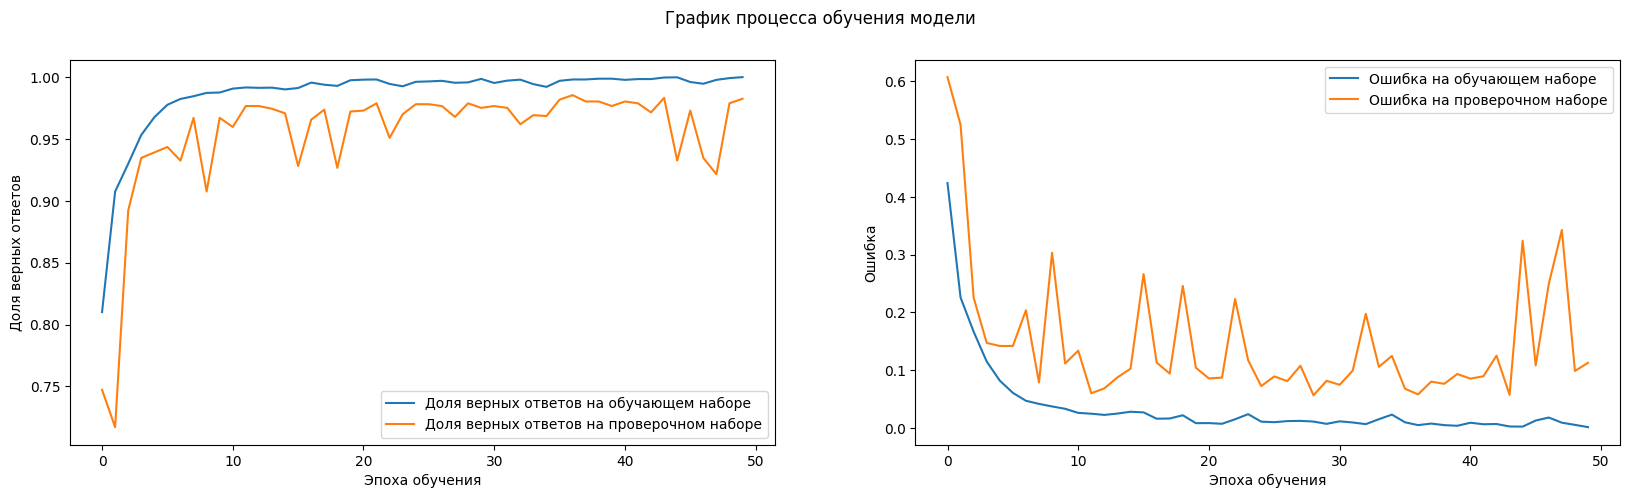

In [83]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('График процесса обучения модели')
ax1.plot(history.history['accuracy'],
            label='Доля верных ответов на обучающем наборе')
ax1.plot(history.history['val_accuracy'],
            label='Доля верных ответов на проверочном наборе')
ax1.xaxis.get_major_locator().set_params(integer=True)
ax1.set_xlabel('Эпоха обучения')
ax1.set_ylabel('Доля верных ответов')
ax1.legend()

ax2.plot(history.history['loss'],
            label='Ошибка на обучающем наборе')
ax2.plot(history.history['val_loss'],
            label='Ошибка на проверочном наборе')
ax2.xaxis.get_major_locator().set_params(integer=True)
ax2.set_xlabel('Эпоха обучения')
ax2.set_ylabel('Ошибка')
ax2.legend()
plt.show()

In [ ]:
model.save_weights("mid.weights.h5") # Сохранение весов модели в файл mid.weights.h5

In [ ]:
model.load_weights("mid.weights.h5") # Загрузка весов модели из файла mid.weights.h5

### Проверка модели

In [ ]:
loss, acc = model.evaluate(test_generator) # Оценка модели на тестовой выборке
print(f"Accuracy: {acc}, loss: {loss}")

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9900 - loss: 0.0571
Accuracy: 0.9860396981239319, loss: 0.08558925986289978
